In [1]:
import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import gridspec
from scipy.optimize import curve_fit
from scipy.signal import blackmanharris
#import math

# input file and data

In [2]:
storepath = "./UT/SpeedTest/"
filename = "12V_3A_10min_2nd"
storename = "12V_3A_10min_2nd"

inverse = False

reference_count_max = 100000

interval = 1e5
overrange = 1000

In [3]:
print("./rawdata/UT_test/" + filename + ".txt")

./rawdata/UT_test/12V_3A_10min_2nd.txt


In [4]:
#input file and data correspondence
error, direction, overflow, timer_count, refcount = np.loadtxt("./rawdata/UT_test/" + filename + ".txt",comments="#",unpack=True)
numlines = len(error)

modError = error[:-1]
diffError = np.diff(error)
modDirection = direction[:-1]
diffDirection = np.diff(direction)
modOverflow = overflow[:-1]
diffOverflow = np.diff(overflow)
modTCount = timer_count[:-1]
diffTCount = np.diff(timer_count)
modReference = refcount[:-1]
diffReference = np.diff(refcount)

In [5]:
numlines

1207399

In [6]:
min(error)

1.0

# check characteristic lines and values

In [7]:
for i in range(numlines-1):
    if diffOverflow[i] > 0:
        print(f'{i}: {diffOverflow[i]}')

34797: 1.0
77711: 1.0
120626: 1.0
163541: 1.0
206456: 1.0
249371: 1.0
292286: 1.0
335202: 1.0
378118: 1.0
421033: 1.0
463950: 1.0
506865: 1.0
549780: 1.0
592696: 1.0
635612: 1.0
678528: 1.0
721444: 1.0
764360: 1.0
807276: 1.0
850191: 1.0
893107: 1.0
936023: 1.0
978938: 1.0
1021854: 1.0
1064769: 1.0
1107685: 1.0
1150601: 1.0
1193516: 1.0


In [8]:
for i in range(numlines-1):
    if refcount[i] > 51999:
        print(f'{i} {refcount[i]}')

140502 52000.0
155608 52000.0
178428 52000.0
299773 52000.0
345628 52000.0
437582 52000.0
640333 52000.0
1099639 52000.0
1145539 52000.0
1183790 52000.0
1191426 52000.0


In [9]:
sum_sawtooth = 0
for i in range(numlines-1):
    if (refcount[i] >= 40000) & (refcount[i-1] < 40000):
        sum_sawtooth += 1
sum_sawtooth

316

In [10]:
sum0 = 0
for i in range(numlines-1):
    if (refcount[i] >= 51988) & (refcount[i-1] < 51988):
        sum0 += 1
sum0

287

In [11]:
max(refcount)

52000.0

# set variables
1. averaging data at 0.1 sec sampling
2. edge_point was created only when wire grid goes in an ordinary direction
3. Caution! counts does not increase during error

In [12]:
time = timer_count/200e6
modTime = time[:-1]
diffTime = np.diff(time)

In [13]:
skip1 = 200
skip2 = 4

sampling_time = interval*5e-9*skip2
sampling_time

0.002

In [14]:
hoge = interval*5e-9*skip1
hoge

0.1

In [15]:
average_refcount = refcount[::skip1]
average_time = time[::skip1]
average_time2 = average_time[:-1]

diffavgTime = np.diff(average_time)
diffavgRef = np.diff(average_refcount)

In [16]:
sawtooth = modReference[diffReference != 0.0]
operation_time = modTime[diffReference != 0.0]

In [17]:
diff_sawtooth = np.diff(sawtooth)
for i in range(len(sawtooth) - 1):
    if diff_sawtooth[i] < 0:
        #print(f'{i} {sawtooth[i]}')
        pass
    pass
edge_point = np.where(diff_sawtooth < 0)[0]

(600.0, 610.0)

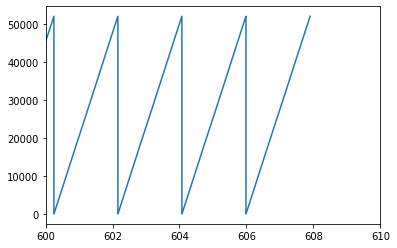

In [18]:
plt.plot(time[edge_point[0]+1:edge_point[-1]+1], sawtooth[edge_point[0]+1:edge_point[-1]+1])
plt.xlim([600,610])

In [19]:
num_sawtooth = []
time_sawtooth = []
sametime_sawtooth = []
for i in range(len(edge_point)-1):
    num_sawtooth.append(sawtooth[edge_point[i]+1:edge_point[i+1]+1])
    time_sawtooth.append(operation_time[edge_point[i]+1:edge_point[i+1]+1])
    sametime_sawtooth.append(operation_time[edge_point[i]+1:edge_point[i+1]+1]-operation_time[edge_point[i]+1])
    pass
#time_sawtooth

In [20]:
#num_sawtooth

In [21]:
signal_endtime1 = np.zeros(len(edge_point)-2)
signal_endtime2 = np.zeros(len(edge_point)-2)

for i in range(len(edge_point)-2):
    signal_endtime1[i] = operation_time[edge_point[i+1]]
    signal_endtime2[i] = sametime_sawtooth[i][-1]
    pass

In [22]:
diffDeg = 360/52000

In [23]:
operation_time2 = []

for i in range(len(edge_point)-1):
    operation_time2 = np.append(operation_time2, time_sawtooth[i])

In [24]:
EachGrad = []
Winding = np.array([])
pack = 200

for i in range(len(edge_point)-1):
    EachGrad.append(max(num_sawtooth[i])/(time_sawtooth[i][-1]-time_sawtooth[i][0]))
    Winding = np.append(Winding, (num_sawtooth[i]-EachGrad[i]*(time_sawtooth[i]-time_sawtooth[i][0]))*diffDeg)
    pass

In [25]:
count_offset = 0
single_saw = np.array([])

for i in range(len(edge_point)-1):
    single_saw = np.append(single_saw, num_sawtooth[i] + count_offset)
    count_offset = single_saw[-1]
    pass

In [26]:
def linear(x,a,b):
    return a*x + b

In [27]:
popt, pcov = curve_fit(linear, operation_time2, single_saw)
popt

array([ 27194.79498928, -95093.97962873])

In [28]:
single_winding = (single_saw-popt[0]*operation_time2-popt[1])*diffDeg

In [29]:
sliced_time = operation_time2[::skip2]

sliced_winding = Winding[::skip2]
sliced_single = single_winding[::skip2]

# plots

Text(0, 0.5, 'end time of one cycle [sec]')

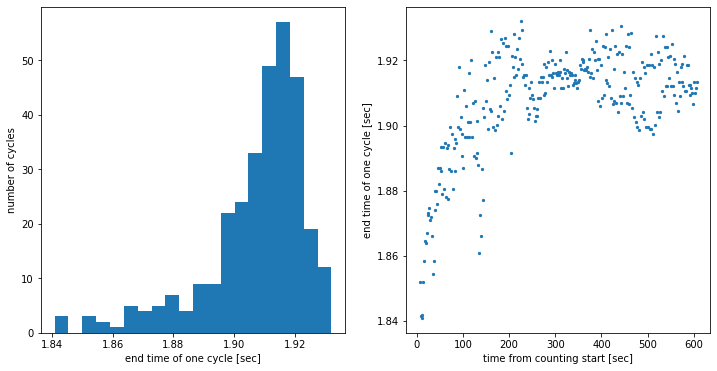

In [30]:
# time dependence of period
fig4, axarr4 = plt.subplots(1,2,figsize=(12,6))
ax4 = axarr4.ravel()
ax4[0].hist(signal_endtime2, bins=20)
ax4[0].set_xlabel('end time of one cycle [sec]')
ax4[0].set_ylabel('number of cycles')
ax4[1].scatter(signal_endtime1, signal_endtime2, s=5)
ax4[1].set_xlabel('time from counting start [sec]')
ax4[1].set_ylabel('end time of one cycle [sec]')

In [114]:
fig4.savefig(storepath + storename + '_PeriodDependence.png')

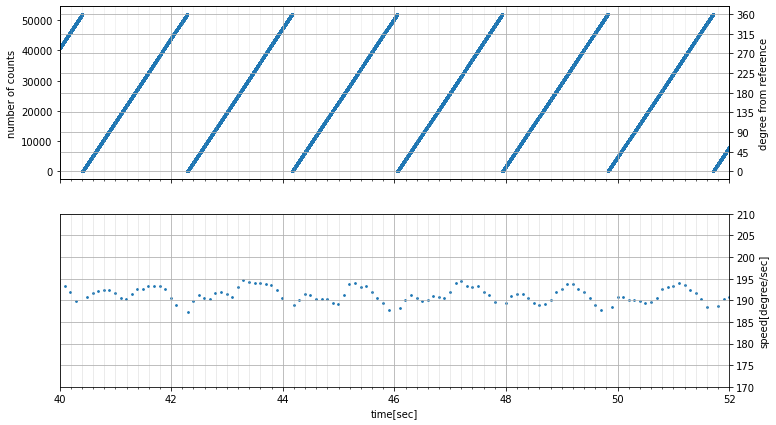

In [112]:
#counts and speed
fig10, axarr10 = plt.subplots(2,figsize = (12,7),sharex=True)
ax10 = axarr10.ravel()
twin_plot = ax10[0].twinx()

ticksmajor = ticker.MultipleLocator(2)
ticksminor = ticker.MultipleLocator(0.2)

ax10[0].xaxis.set_major_locator(ticksmajor)
ax10[0].xaxis.set_minor_locator(ticksminor)
ax10[0].scatter(time,refcount,s=3)
ax10[0].set_ylabel("number of counts")

ax10[0].grid(axis='x',which='major',alpha=1)
ax10[0].grid(which='minor', alpha=0.2)
#ax10[0].grid(axis='x',which='minor',alpha=0.2)

twin_plot.scatter(time,refcount*diffDeg,s=0)
twin_plot.set_ylabel("degree from reference")
twin_plot.yaxis.set_major_locator(ticker.IndexLocator(base=45, offset=0))
twin_plot.grid(which='major',alpha=1)

ax10[1].set_xlim([40,52])

ax10[1].set_ylim([170,210])
ax10[1].xaxis.set_major_locator(ticksmajor)
ax10[1].xaxis.set_minor_locator(ticksminor)
ax10[1].scatter(average_time2,diffavgRef/diffavgTime*diffDeg, s=3)
ax10[1].set_xlabel("time[sec]")
ax10[1].yaxis.set_label_position("right")
ax10[1].yaxis.tick_right()
ax10[1].grid(which='minor',alpha=0.3)
ax10[1].set_ylabel("speed[degree/sec]")
ax10[1].grid()

In [113]:
fig10.savefig(storepath + storename + "_CountVsSpeed.png")

Text(0, 0.5, 'number of counts')

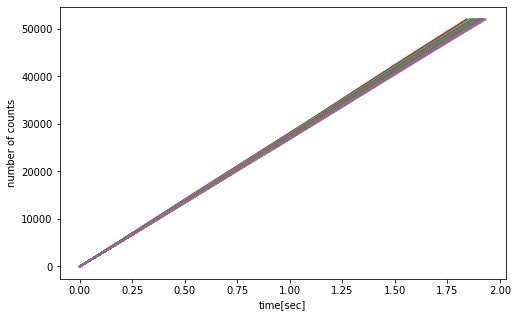

In [34]:
#piled signal
fig20 = plt.figure(figsize=(8,5))
for i in range(len(edge_point)-2):
    plt.plot(sametime_sawtooth[i],num_sawtooth[i],label=f'signal_{i}')
#plt.legend()
plt.xlabel("time[sec]")
plt.ylabel("number of counts")

In [35]:
#fig20.savefig(storepath + storename + "_piledSig.png")

Text(0, 0.5, 'speed[mm/sec]')

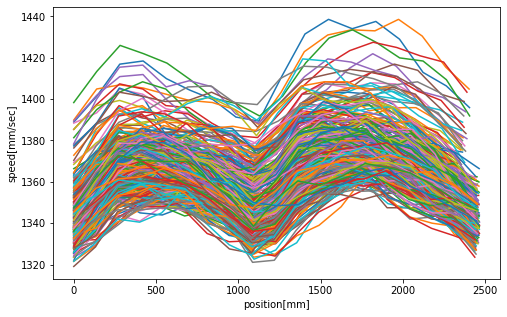

In [36]:
#speed of each signal
fig30 = plt.figure(figsize=(8,5))
start_position = []
for i in range(len(edge_point)-2):
    start_position.append(num_sawtooth[i][::skip1])
    pass
for i in range(1,len(edge_point)-3):
    #if len(np.diff(time_sawtooth[i])) > 51000:
        plt.plot(start_position[i][:-1]*50e-3,
                 np.diff(start_position[i])*50e-3*skip1/(np.diff(time_sawtooth[i][::skip1])*skip1),
                 label=f'signal_{i}')
plt.xlabel("position[mm]")
plt.ylabel("speed[mm/sec]")
#plt.legend()

In [37]:
#fig30.savefig(storepath + storename + "_SpeedGrad.png")

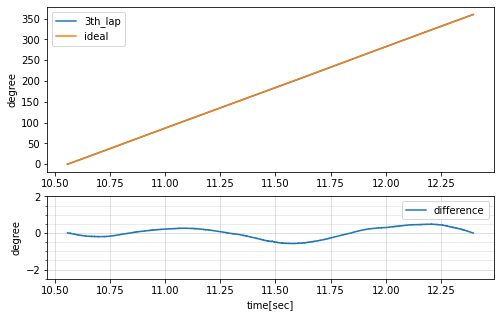

In [38]:
#variance of position
fig40 = plt.figure(figsize=(8,5))
num_lap = 3

CountGrad = max(num_sawtooth[num_lap])/(time_sawtooth[num_lap][-1]-time_sawtooth[num_lap][0])
spec = gridspec.GridSpec(ncols=1,nrows=2,height_ratios=[2,1])

ax41 = fig40.add_subplot(spec[0])
ax41.plot(time_sawtooth[num_lap],num_sawtooth[num_lap]*diffDeg,label=f'{num_lap}th_lap')
ax41.plot(time_sawtooth[num_lap],CountGrad*(time_sawtooth[num_lap]-time_sawtooth[num_lap][0])*diffDeg,label='ideal')
ax41.set_ylabel("degree")
ax41.legend()

ax42 = fig40.add_subplot(spec[1])
ax42.plot(time_sawtooth[num_lap],
          (num_sawtooth[num_lap]-CountGrad*(time_sawtooth[num_lap]-time_sawtooth[num_lap][0]))*diffDeg,
          label='difference')
ax42.set_xlabel("time[sec]")
ax42.set_ylabel("degree")
ax42.set_yticks(np.arange(-2.5,2.5,0.5),minor=True)
ax42.grid(which='major',alpha=0.5)
ax42.grid(which='minor',alpha=0.3)
ax42.legend()
#ax42.set_xlim([28.0,28.1])
#ax42.set_ylim([-0.1,0.1])

In [39]:
#fig40.savefig(storepath + storename + f'_{num_lap}th_lap_DegWinding.png')

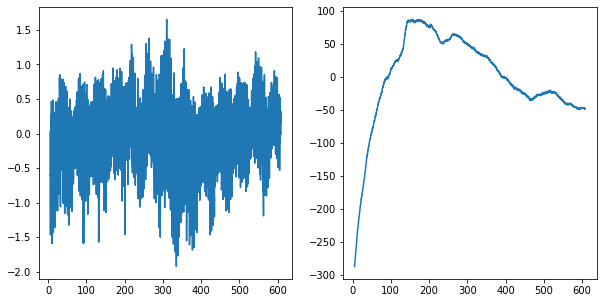

In [40]:
#winding signal
fig50, axarr50 = plt.subplots(1,2,figsize=(10,5))
ax50 = axarr50.ravel()

ax50[0].plot(sliced_time, sliced_winding)
ax50[1].plot(sliced_time, sliced_single)

In [41]:
#Fourier
Fourier1 = np.fft.fft(sliced_winding)
Freq1 = np.fft.fftfreq(len(sliced_time),d=sampling_time)
Amp1 = np.abs(Fourier1/(len(sliced_time)/2))

Fourier2 = np.fft.fft(sliced_single)
Freq2 = np.fft.fftfreq(len(sliced_time),d=sampling_time)#*(single_time[-1]-single_time[0])
Amp2 = np.abs(Fourier2/(len(sliced_time)/2))

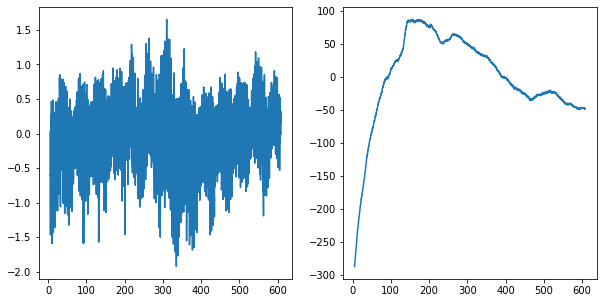

In [42]:
#inversed fourier
iFourier1 = np.fft.ifft(Fourier1)
ReInvFour1 = iFourier1.real
iFourier2 = np.fft.ifft(Fourier2)
ReInvFour2 = iFourier2.real

fig51, axarr51 = plt.subplots(1,2,figsize=(10,5))
ax51 = axarr51.ravel()

ax51[0].plot(sliced_time, ReInvFour1)
ax51[1].plot(sliced_time, ReInvFour2)

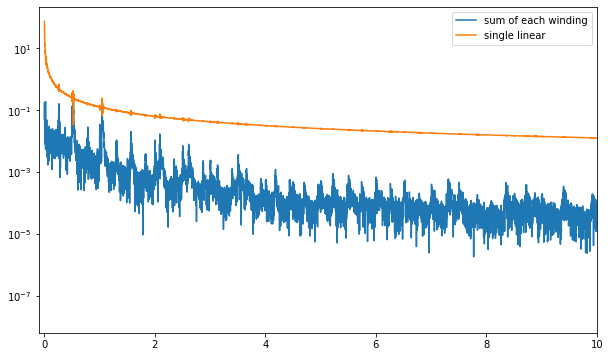

In [43]:
#fourier spectrum
fig52 = plt.figure(figsize=(10,6))

plt.semilogy(Freq1[1:int(len(sliced_time)/2)], Amp1[1:int(len(sliced_time)/2)], label='sum of each winding')
plt.semilogy(Freq2[1:int(len(sliced_time)/2)], Amp2[1:int(len(sliced_time)/2)], label='single linear')
plt.xlim([-0.1,10])
plt.legend()

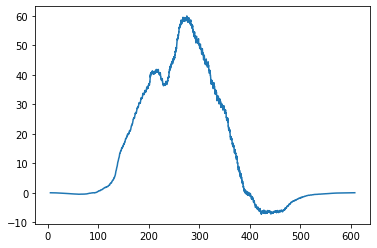

In [44]:
# window fourier
window = blackmanharris(len(sliced_single))
window_signal = sliced_single*window
plt.plot(sliced_time, window_signal)

Fourier = np.fft.fft(window_signal)
Freq = np.fft.fftfreq(len(sliced_time), d=sampling_time)
correction = 1/(sum(window)/len(sliced_single))
Amp = np.abs(Fourier/(len(sliced_time)/2))*correction

In [45]:
for i in range(int(len(single_winding[::pack])/2)):
    if Amp[i] > 0.001:
        if Amp[i] > Amp[i-1] and Amp[i] > Amp[i+1]:
            print(f'{i} {round(Freq[i],4)} {round(Amp[i],4)}')

0 0.0 76.7468
6 0.01 4.1893
16 0.0266 0.58
18 0.0299 0.7705
23 0.0382 0.4839
26 0.0432 0.313
31 0.0515 0.4153
34 0.0564 0.383
37 0.0614 0.2569
44 0.073 0.1668
47 0.078 0.1612
54 0.0896 0.1555
60 0.0996 0.0812
64 0.1062 0.1203
68 0.1129 0.1199
71 0.1179 0.0812
75 0.1245 0.0309
78 0.1295 0.0605
83 0.1378 0.0781
87 0.1444 0.0566
89 0.1477 0.0372
91 0.1511 0.0392
96 0.1594 0.029
98 0.1627 0.0376
103 0.171 0.0654
106 0.176 0.0323
111 0.1843 0.0273
114 0.1892 0.018
118 0.1959 0.0328
123 0.2042 0.0342
128 0.2125 0.0723
131 0.2175 0.0497
134 0.2224 0.0336
141 0.2341 0.0511
148 0.2457 0.0303
154 0.2556 0.17
158 0.2623 0.5116
162 0.2689 0.1058
168 0.2789 0.0504
176 0.2922 0.0107
179 0.2971 0.03
187 0.3104 0.0258
194 0.322 0.0233
197 0.327 0.0109
200 0.332 0.0213
203 0.337 0.0128
206 0.342 0.0079
210 0.3486 0.0117
212 0.3519 0.0161
216 0.3586 0.006
220 0.3652 0.015
225 0.3735 0.0216
228 0.3785 0.015
232 0.3851 0.0047
237 0.3934 0.0087
242 0.4017 0.0164
248 0.4117 0.0113
253 0.42 0.0071
257 0.4266

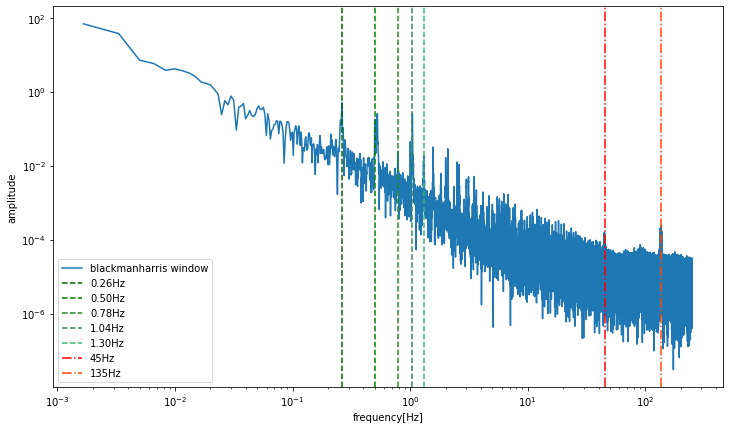

In [81]:
# Fourier Frequancy and Amplitude
fig61 = plt.figure(figsize=(12,7))

#plt.semilogy(Freq1[1:int(len(sliced_time)/2)], Amp1[1:int(len(sliced_time)/2)], label='sum of each winding')
#plt.semilogy(Freq2[1:int(len(sliced_time)/2)], Amp2[1:int(len(sliced_time)/2)], label='single winding')
plt.loglog(Freq[1:int(len(sliced_time)/2)], Amp[1:int(len(sliced_time)/2)], label='blackmanharris window')
#plt.xlim([30,150])
plt.xlabel('frequency[Hz]')
plt.ylabel('amplitude')
plt.axvline(0.263, color='darkgreen', ls='--', label='0.26Hz')
plt.axvline(0.501, color='green', ls='--', label='0.50Hz')
plt.axvline(0.786, color='forestgreen', ls='--', label='0.78Hz')
plt.axvline(1.044, color='seagreen', ls='--', label='1.04Hz')
plt.axvline(1.304, color='mediumseagreen', ls='--', label='1.30Hz')
# plt.axvline(1.187, color='limegreen', ls='--', label='1.2Hz')
# plt.axvline(1.440, color='lime', ls='--', label='1.4Hz')
# plt.axvline(1.653, color='springgreen', ls='--', label='1.6Hz')
# plt.axvline(2.066, color='aquamarine', ls='--', label='2.0Hz')
plt.axvline(45, color='red', ls='-.', label='45Hz')
plt.axvline(135, color='orangered', ls='-.', label='135Hz')
plt.legend()

In [47]:
#fig61.savefig(storepath + storename + '_windowFourier2.png')

In [82]:
hoge_time = time[edge_point[0]+1:edge_point[-1]+1]
hoge_signal = sawtooth[edge_point[0]+1:edge_point[-1]+1]

hoge_window = blackmanharris(len(hoge_time))

hoge_fourier = np.fft.fft(hoge_signal*diffDeg*hoge_window)
hoge_freq = np.fft.fftfreq(len(hoge_time), d=0.002)
hoge_correction = 1/(sum(hoge_window)/len(hoge_time))
hoge_amp = np.abs(hoge_fourier/(len(hoge_time)/2))*hoge_correction

(10.0, 16.0)

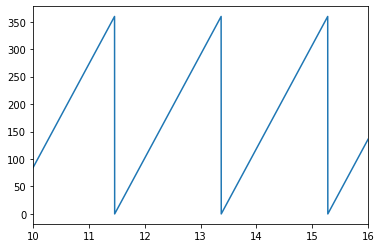

In [83]:
test_end = 600
test_dt = 0.002
test_time = np.arange(0,test_end,test_dt)

steps = len(test_time)

g = test_time%1.91
plt.plot(test_time,g*360/1.91)
plt.xlim([10,16])

In [84]:
for i in range(int(len(single_winding[::pack])/2)):
    if hoge_amp[i] > 0.001:
        if hoge_amp[i] > hoge_amp[i-1] and hoge_amp[i] > hoge_amp[i+1]:
            print(f'{i} {round(hoge_freq[i],4)} {round(hoge_amp[i],4)}')

0 0.0 359.7822
6 0.0025 0.0262
9 0.0037 0.0146
13 0.0054 0.1961
19 0.0079 0.0236
23 0.0095 0.0133
26 0.0108 0.054
29 0.012 0.0128
34 0.0141 0.0111
38 0.0158 0.0194
41 0.017 0.0136
45 0.0187 0.0121
51 0.0212 0.033
56 0.0232 0.0116
59 0.0245 0.0126
65 0.027 0.0223
70 0.0291 0.0181
77 0.032 0.0085
83 0.0344 0.0102
86 0.0357 0.0167
90 0.0374 0.0208
94 0.039 0.0135
97 0.0403 0.0055
100 0.0415 0.0075
103 0.0427 0.0162
107 0.0444 0.0182
110 0.0457 0.01
115 0.0477 0.0205
120 0.0498 0.03
127 0.0527 0.0231
133 0.0552 0.009
136 0.0564 0.0334
139 0.0577 0.0239
146 0.0606 0.0404
153 0.0635 0.1553
156 0.0647 0.5049
161 0.0668 0.1677
167 0.0693 0.0259
174 0.0722 0.0416
180 0.0747 0.0384
184 0.0764 0.0488
187 0.0776 0.0643
192 0.0797 0.031
197 0.0818 0.0387
204 0.0847 0.0354
208 0.0863 0.044
212 0.088 0.0666
217 0.0901 0.0327
219 0.0909 0.0223
224 0.093 0.0353
228 0.0946 0.0576
231 0.0959 0.0858
237 0.0984 0.0664
240 0.0996 0.0257
244 0.1013 0.0896
247 0.1025 0.1305
250 0.1038 0.0966
255 0.1058 0.0753

In [85]:
1/1.91

0.5235602094240838

(10.0, 30.0)

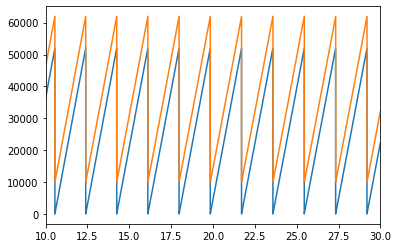

In [86]:
plt.plot(hoge_time, hoge_signal)
plt.plot(sliced_time, single_saw[::skip2]%52000+10000)

plt.xlim([10,30])

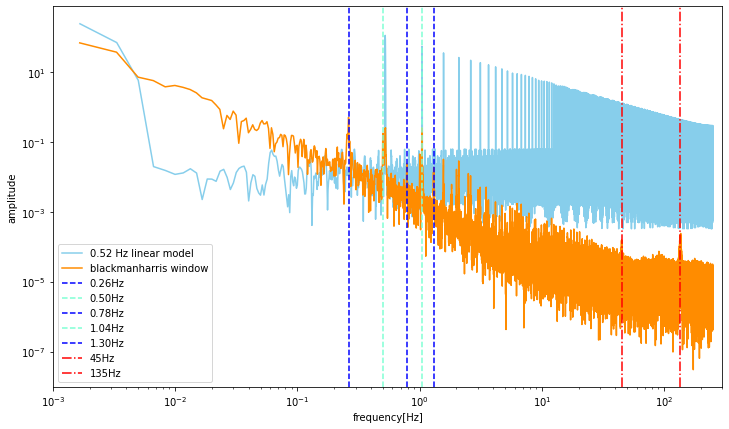

In [105]:
figX = plt.figure(figsize=(12,7))
test_window = blackmanharris(steps)
test_correction = 1/(sum(test_window)/steps)

test_F = np.fft.fft(g*360/1.91*test_window)
test_result = np.fft.fftfreq(steps,d=test_dt)
test_amp = np.abs(test_F/(steps/2))*test_correction

plt.loglog(test_result[1:int(steps/2)],test_amp[1:int(steps/2)], color='skyblue', label='0.52 Hz linear model')
#plt.loglog(hoge_freq[1:int(len(hoge_time)/2)],hoge_amp[1:int(len(hoge_time)/2)], label='raw')
plt.loglog(Freq[1:int(len(sliced_time)/2)], Amp[1:int(len(sliced_time)/2)], color='darkorange', label='blackmanharris window')
plt.xlabel('frequency[Hz]')
plt.ylabel('amplitude')
plt.axvline(0.263, color='blue', ls='--', label='0.26Hz')
plt.axvline(0.501, color='aquamarine', ls='--', label='0.50Hz')
plt.axvline(0.786, color='blue', ls='--', label='0.78Hz')
plt.axvline(1.044, color='aquamarine', ls='--', label='1.04Hz')
plt.axvline(1.304, color='blue', ls='--', label='1.30Hz')
plt.axvline(45, color='red', ls='-.', label='45Hz')
plt.axvline(135, color='red', ls='-.', label='135Hz')
plt.xlim([1e-3, 3e2])
plt.legend()

In [106]:
figX.savefig(storepath + storename + '_ComparedFourier2.png')

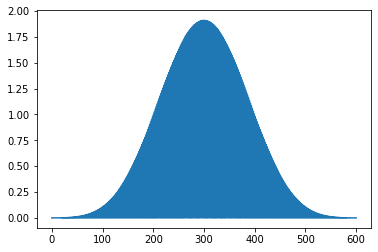

In [89]:
plt.plot(test_time, g*test_window)

In [90]:
hoge2_window = blackmanharris(len(sliced_time))
hoge2_correction = 1/(sum(hoge2_window)/len(sliced_time))

hoge2 = np.fft.fft(single_saw[::skip2]%52000*360/52000)
hoge2_freq = np.fft.fftfreq(len(sliced_time), d=0.002)
hoge2_amp = np.abs(hoge2/(len(sliced_time)/2))*hoge2_correction

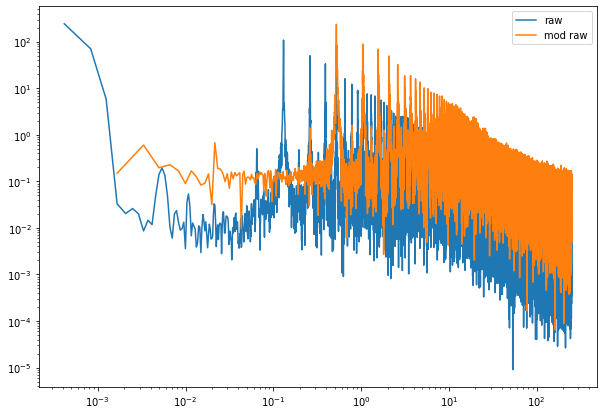

In [91]:
figY = plt.figure(figsize=(10,7))

plt.loglog(hoge_freq[1:int(len(hoge_time)/2)],hoge_amp[1:int(len(hoge_time)/2)], label='raw')
plt.loglog(hoge2_freq[1:int(len(sliced_time)/2)],hoge2_amp[1:int(len(sliced_time)/2)], label='mod raw')
plt.legend()

In [107]:
817.2/41.8

19.550239234449762

In [109]:
817.2/41.8/2

9.775119617224881

In [110]:
817.2/41.8/2*5

48.875598086124405

In [111]:
817.2/41.8/2*5*60

2932.535885167464

# histogram and others for data points

In [58]:
if inverse is True:
    region = np.where(diffReference < 0)[0]
    start = region[0] - overrange
    stop = region[-1] + overrange
else:
    region = np.where(diffReference > 0)[0]
    start = region[0] - overrange
    stop = region[-1] + overrange

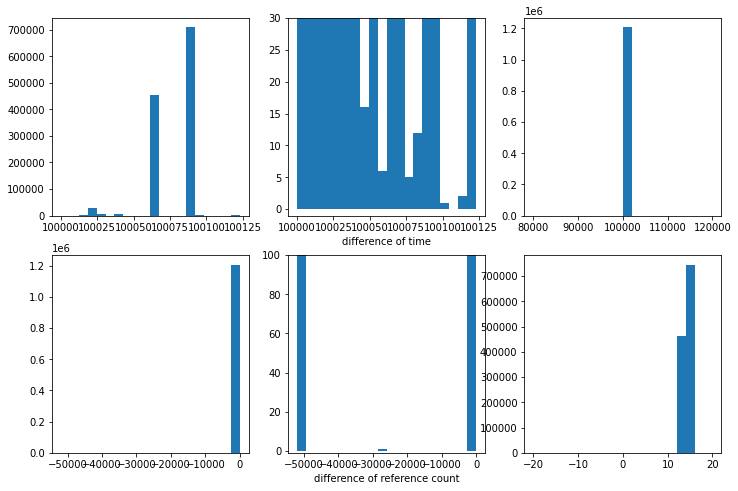

In [59]:
#data histogram
fig0, axarr0 = plt.subplots(2,3,figsize=(12,8))
ax0 = axarr0.ravel()
ax0[0].hist(diffTCount, bins = 20)
ax0[1].hist(diffTCount, bins = 20)
ax0[1].set_ylim([-1,30])
ax0[1].set_xlabel('difference of time')
ax0[2].hist(diffTCount, bins = 20,range = (interval*0.8, interval*1.2))
ax0[3].hist(diffReference, bins = 20)
ax0[4].hist(diffReference, bins = 20)
ax0[4].set_ylim([-1,100])
ax0[4].set_xlabel('difference of reference count')
if inverse is True:
    ax0[5].hist(diffReference, bins = 20, range = (-2*interval*1e-4, 2*interval*1e-4))
else:
    ax0[5].hist(diffReference, bins = 20, range = (-2*interval*1e-4, 2*interval*1e-4))

In [60]:
#fig0.savefig(storepath + storename + "_hist.png")

Text(0, 0.5, 'difference of counts')

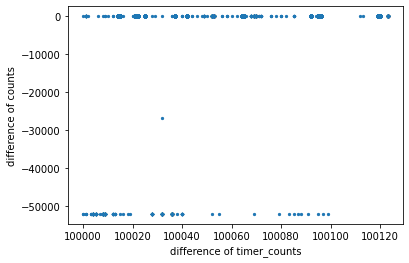

In [61]:
fig1 = plt.figure()
plt.scatter(diffTCount,diffReference,s=5)
plt.xlabel('difference of timer_counts')
plt.ylabel('difference of counts')

In [62]:
#fig1.savefig(storepath + storename + "_relationTandC.png")

(-4000.0, 50.0)

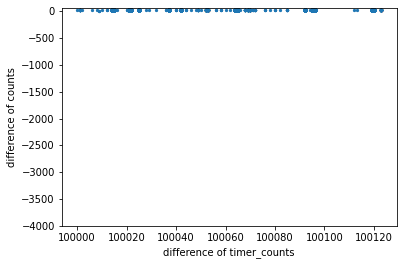

In [63]:
plt.scatter(diffTCount,diffReference,s=5)
plt.xlabel('difference of timer_counts')
plt.ylabel('difference of counts')
plt.ylim([-4e3,50])

Text(0.5, 0, 'lines')

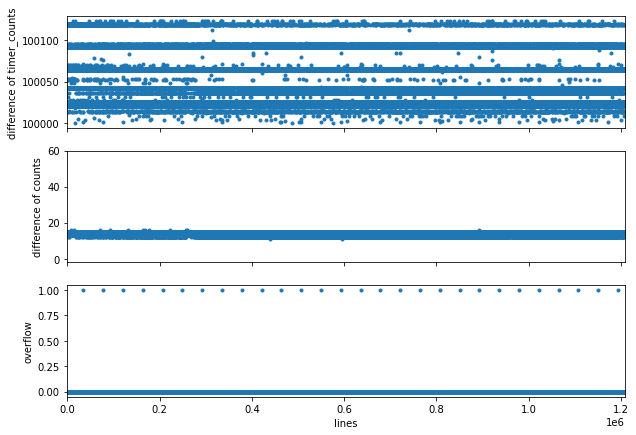

In [64]:
#charactaristical values
fig2, axarr2 = plt.subplots(3,sharex=True,figsize=(10,7))
ax2 = axarr2.ravel()
ax2[0].plot(diffTCount, ls='', marker='.')
ax2[0].set_ylabel("difference of timer_counts")
ax2[0].set_xlim([start,stop])
#ax2[0].set_ylim([-1,30])
ax2[1].plot(diffReference, ls='', marker='.')
ax2[1].set_ylabel("difference of counts")
if inverse is True:
    ax2[1].set_ylim([-60,2])
else:
    ax2[1].set_ylim([-2,60])
ax2[2].plot(diffOverflow, ls='', marker='.')
ax2[2].set_ylabel("overflow")
ax2[2].set_xlabel("lines")

In [65]:
#fig2.savefig(storepath + storename + "_behavior.png")

(-1000.0, 1208397.0)

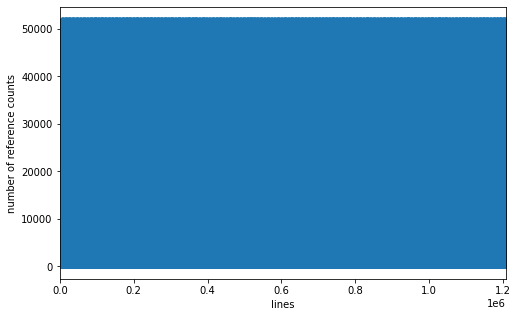

In [66]:
fig3 = plt.figure(figsize=(8,5))
plt.plot(refcount, ls='', marker='.')
#plt.plot(diffOverflow*0.5*reference_count_max, ls='', marker='.')
plt.xlabel("lines")
plt.ylabel("number of reference counts")
plt.xlim([start,stop])

In [67]:
#fig3.savefig(storepath + storename + "_rowVSrefcount.png")

# others